**Note on the imported packages.** At some point, we will use Naima here, and if I understand correctly, it requires Numpy v. < 2. But I had Numpy of the version 2...! So you can either downgrade Numpy to <2, or (what my best friend ChatGPT said to do) create an environment with Numpy < 2 and Naima installed (and some other packages which do not seem to be in conflict with Numpy or Naima). If you follow the second way, ensure that this Notebook is launched from the right environment. 

But if you just want to use IBSEn for Orbit / Winds & Stars / IBS / electron evolution and NOT for specta / light curves, you're good to go without Naima.

![scheme_tot](../../Pictures/ProjectScheme.png)



In [1]:
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
import ibsen


DAY = 86400.
AU = 1.5e13


First, initialize the system you want to work with. I use the cartesian coordinate system with the origin in the optical star, the x-axis is directed to the periastron of the pulsar orbit, z-axis is directed as the angular velocity of the pulsar $\mathbf{\Omega}_{puls}$, y-axis is perpendicular to $x$ and $y$ directed so that $\mathbf{e}_x \times \mathbf{e}_y = \mathbf{e}_z$.

![coords](../../Pictures/fig_orbit_coords.jpg)

For this, create a class ``orb:Orbit`` that would be passed as an argument in future to everything else. Once it is created, you can obtain some orbit parameters (orbital periond, eccentricity, etc.) or the arrays of coordinates (x, y, r, ...) along the orbit.

See Orbit_expanded for the full tutorial on all parameters and on what Orbit class can do.
Here, we show three ways of initializing an orbit:
(1) with a keyword, (2) with a keyword + some parameters, and (3) with all parameters explicitly stated. 

The simplest way to initialize the orbit is like this:

**TODO: add the names of other gamma-ray binaries so they would be recognized.**

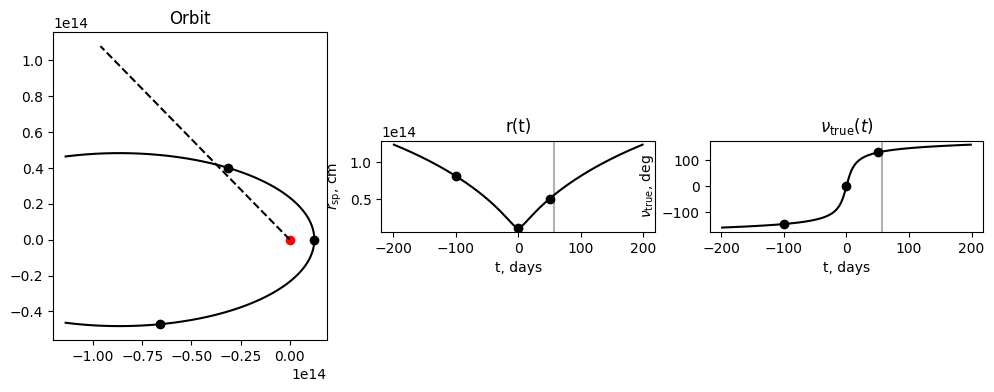

In [2]:
from ibsen.orbit import Orbit

"""
This is the simplest way of initializing an orbit: by a keyword sys_name = ...
The only available options are
(1) 'psrb' (PSR B1259-63), or
(2) 'rb' and (3) 'bw' for typical values for redback and black widow spider pulsar systems.
"""

sys_name = 'psrb' 
orb = Orbit(sys_name = sys_name, n=1003)
orb.peek(ax=None, # optional, for usage see further
         showtime=[-200*DAY, 200*DAY], # which part of the orbit to display
         times_pos = [-100*DAY, 0, 50*DAY], # time points at which to display a dot on the orbit
         xplot = 'time', # whether x-axis is time [days]  or phase (then xplot = 'phase')
         color='k')

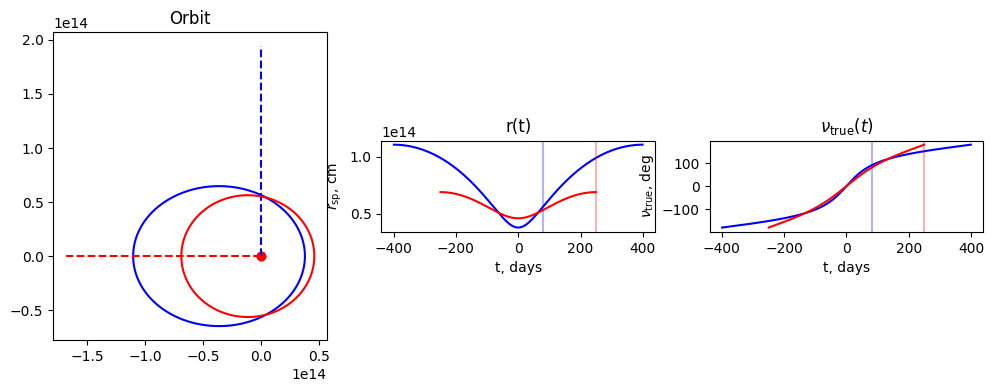

In [3]:

"""
You also can pass period, e, tot_mass, and nu_los as arguments, and these 
explicitly provided parameters will overwrite the default ones:
"""

orb_new = Orbit(sys_name = sys_name, period = 800. * DAY, e = 0.49, nu_los=pi/2.)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
orb_new.peek(ax=ax, color='b')

"""
Finally, you can initialize the orbit by providing the dictionary with the following keywords.
"""

orb_my_dict = {
             'e': 0.2, # eccentriciry. Necessary for orbit
             'M': 30. * 2e33, # total mass m1 + m2 [g]. The code does NOT check that M = Mopt + M_ns. Necessary for orbit
             'T': 500 * DAY, # the orbital period [s]. Necessary for orbit
             'nu_los': pi, # the angle between the star-to-periastron direction
             # and the direction to the observer (= 3pi/2 - \omega) [rad]
             # Necessary for orbit.

             'Ropt': 12 * 7e10, # the optical star radius [cm]. Necessary for winds (later)
             'Topt': 3.4e3, # the optical star effective temperature [K]. Necessary for winds (later)
             'Mopt': 28.6 * 2e33, # the optical star mass [g]. Necessary for winds (later)
             'D': 3e3 * 3e18, # the distance to the system [cm]. Necessary for spectrum (later)
             'M_ns': 1.4 * 2e33, # the neutron star mass [g]. Not necessary, can be skipped
           }

orb_my = Orbit(sys_name = orb_my_dict) #### If you explicitly set something as an argument here,
                                        ### e.g. T=700*Day,
                                       #### it overrites the value from the dictionary

orb_my.peek(ax=ax, color='r')


Now, let us initialize the winds with the class ``winds:Winds``. Quick remark: Apart from outflows-related stuff, I temporarily put everything related to the properties of an NS (P, meaning ''pulsar'') and an optical star (S, meaning ''Star'') in this class: so temperature/radius of S, magnetic fields as functions of r (**TODO**) --- are all initialized/calculated here.  In this class, there are also their magnetic fields and functions for calculating them at some distance and at the shock apex (at time $t$) and the same for the photon field of the optical star. 

Anyway, about the outflows. See the tutorial `Winds_expanded` for an overview of models I use for winds. Shortly, the pulsar wind is assumed spherically symmetrical; the Be outflows consist of a spherically-symmetric polar wind and a decretion disk in a rotation plane of the Be-star.

Here you can also calculate the distance at which $P_w + P_d = P_p$ and calculate the effective relation between winds momenta at the moment of time after the periastron passage $t$.



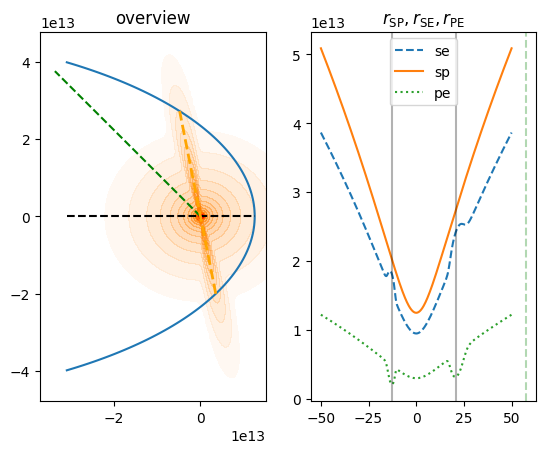

In [4]:
from ibsen.winds import Winds

# having initialized orb:Orbit, initialize winds:Winds

winds = Winds(orbit=orb, sys_name = sys_name, alpha=10/180*pi, incl=23*pi/180,
              f_d=165, f_p=0.1, delta=0.01, np_disk=3, rad_prof='pl', r_trunk=None,
             height_exp=0.25)
winds.peek(ax=None,
           showtime = (-50*DAY, 50*DAY), # optional. Default is (-T/2, T/2)
           plot_rs = True # whether to plot the dependence of r_pe/se/sp on time
          )


Now it's time for the intrabinary shock (ibs) from class IBS. I use the model from Canto, Raga, and Wilkin

https://ui.adsabs.harvard.edu/abs/1996ApJ...469..729C/abstract

in which (if coordinates are in units of birary separation) the shock shape depends only on one parameter $\beta$, the relation between the pulsar and the optical star _spherical_ winds momenta. 

To initialize the IBS, you need ``beta`` (float) and ``s_max`` which defines where the shock ends.

**TODO: or a string ''bow'' (then only such part of the IBS left that $\theta \leq 90^\circ$), or a string ''incl'' (then only such part of the IBS left that the angle between the tangent and the direction to the pulsar is $\leq 90^\circ + 10^\circ$).**

There are two IBS classes. The first one, IBS_norm, works only with dimentionless units (all lengths are normalized to the binary separation, so that $r_{sp}=1$. The second one accepts winds:Winds along with the time at which to set IBS, and calculates the effective $\beta$ from the pressure balance equations. 

First, I demonstrate how IBS_norm works. It accepts $\beta$, s_max, and parameters of bulk motion of matter along the shock s_max_g and $\Gamma_\mathrm{max}$:

\begin{equation}
    \Gamma(s) = 1 + (\Gamma_\mathrm{max}-1)\frac{s}{s_\mathrm{max~g}}
\end{equation}

You can also rotate the shock at any angle, calculate doppler factors, photon scattering angle (from star - to IBS - to the observer), and the same angle in the frame co-moving with the matter. Upon initializing, the class obtains the values x, y, s (arclength from apex to the given point), r, theta, r1, theta1, tangent (the angle between the tangent to a given point and the x-axis), thetainf (the max angle theta), and x_apex (the distance from the pulsar to the IBS apex). Also defined are: x, y, s, theta in the segments centers.


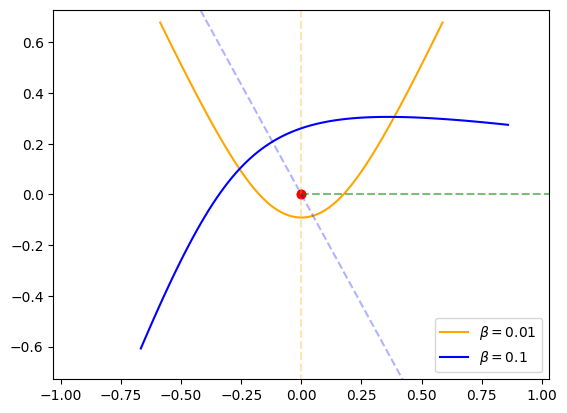

In [5]:
from ibsen.ibs import IBS
from ibsen.ibs_norm import IBS_norm
## draw two rotated shocks, in dimentionless units.
fig, ax = plt.subplots(1, 1)
beta1 = 0.01
ibs1 = IBS_norm(beta=beta1, n=51, s_max = 1, gamma_max=2, s_max_g=1).rotate(-90*pi/180) 

ibs1.peek(ax=ax, ibs_color='orange', to_label=True)
beta2 = 0.1
ibs2 = IBS_norm(beta=beta2, n=51, s_max = 1, gamma_max=2, s_max_g=1).rotate(120*pi/180)
ibs2.peek(ax=ax, ibs_color='blue', to_label=True)


/home/alvkuzin/whole_psrb_project/src/ibsen/ibs.py:325: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


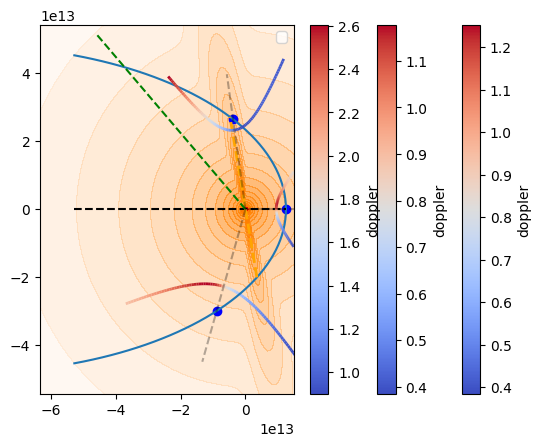

In [6]:
##### now let's defnie the IBS with the kinematics of the bulk motion and draw
##### several IBSs in several times with color corresponding to the Doppler factor

##### For t = 25 days, 0, and 20 days, draw an IBS calculated from the winds initialized
##### before. Draw it with color corresponding to the doppler factor delta.

fig, ax = plt.subplots(1, 1)
show_winds = True
for t in (-25*DAY, 0*DAY, 20*DAY):
    ibs = IBS(
              gamma_max=3.,     # max bulk motion gamma
              s_max=1.,         # where to cut IBS. s_max = 1 means 'cut it where the arclength
                                # along the shock is equal to the 1 orbital separation at a given time'
                                # can also be strings ``bow`` or ``incl``.
        
              s_max_g=4,        # a parameter of a linear function Gamma(s) 
              n=41,             # number of points in ONE horn of IBS to initialize
        
              winds = winds,    # previously initialized class winds:Winds to calculate beta_eff
              t_to_calculate_beta_eff=t  # when to calculate beta_eff
              )
    # show winds once
    ibs.peek(fig=fig, ax=ax,
                  show_winds=show_winds, # self-explanatory. winds:Winds should be provided. Default is False.  
                  ibs_color='doppler', # either real color to put to matplotlib OR {'doppler', 
                                         # 'scattering', 'scattering_comoving'}.
                  showtime = (-80*DAY, 80*DAY) # to put into winds.peek()
                 )
    show_winds = False
 
                                                 
# ax.set_xlim(-0.5e14, 0.3e14)                                             
# ax.set_ylim(-orb.b*1.2, orb.b*1.2)

Now it's time to do something useful. Let's calculate the spectrum of relativistic electrons in each point of IBS that we have just initialized. There are many parameters that you should/may specify for this, so the full list is in the example below right in the Python code, with descriptions and default values. Here's a short desctiption, see ``ElectronEvolution_expanded`` tutorial for the more complete explanation.

First of all, you can set ``cooling='no'``, and the spectrum of electrons in each $s$ will be (numerically) set to the injection function $Q_\mathrm{inj}(s, E)$. Note that from the physical point of view this is nonsense, as $Q$ is the number of $\mathrm{e}^-$ injected per unit of time (per cm per eV) ($\mathrm{s}^{-1}$), so $Q\times (E/\dot E)$ gives the numer of particles (per cm per eV), but setting ``cooling='no'`` ignores the dimentions difference and just sets $n(s, E) \equiv Q(s, E)$.

All other options allow to find an electron spectrum $n(s, e) = d\dot N_e/ds/de$. 

- ``cooling=stat_apex`` calculates the stationary e-spectrum on each $s$ using magnetic and photon fields as in the IBS apex;
- ``cooling=stat_ibs`` calculates the stationary e-spectrum on each $s$ using magnetic and photon fields in this point on IBS;
- ``cooling=stat_mimic`` calculates the stationary e-spectrum on each $s$ with the ''adiabatic time'' $t_a$ calculated to mimic the ''proper'' advection equation solution;
- ``cooling=adv`` solves the 2-dimentional advection-over-s + coooling-over-e equation with the same $\dot E$ as before but without ''advection losses''.
  **And experimental options:**
 - ``cooling=leak_apex``,
 - ``cooling=leak_ibs``,
 - ``cooling=leak_mimic``.
The names have the same meaning as for ``stat`` options, but the equation with leakage is being solved instead.

The IBS you provide should be ``ibs:IBS`` class, not ``ibs:IBS_norm``.

At the moment of initializing the class, the spectra $n_e(s,E)$ are not calculated yet (as the calculation may take a while but you maybe just want to know how the magnetic field is distributed along the shock and don't care for e-spectrum). To actually calculate $n_e$, you should do  ``els.calculate()``.

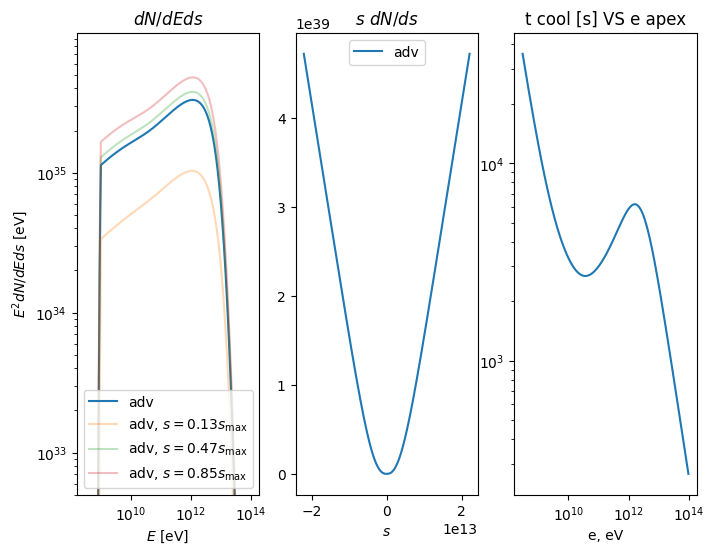

In [16]:
from ibsen.el_ev import ElectronsOnIBS
from scipy.integrate import trapezoid

##### let's again initialize an IBS at, say, 15 days after periastron. Let's do that for three different 
##### models of cooling: stat_ibs, stat_mimic, and adv.
t = 15 * DAY
Nibs = 141
ibs = IBS(winds=winds,
          gamma_max=3.,
          s_max=1.,
          s_max_g=4.,
          n=Nibs,
          t_to_calculate_beta_eff=t) # the same IBS as before
els = ElectronsOnIBS(
                     Bp_apex=0.2, # The magnetic field [G] in the Apex of the IBS coming from pulsar. Mandatory.
                     ibs=ibs, # The IBS at which the e-spec should be calculated. Mandatory.
                     cooling='adv', # How to cool the particles. Default is 'no'.
                     to_inject_e = 'ecpl', # The injection spectrum keyword. Current options: 'ecpl' (default) or 'pl'.
                     to_inject_theta = '3d', # If '2d', then injection distribution over theta is uniform. 
                                             # If '3d' (default), then \propto sin(theta). 
    
                     ecut = 5.e12,  # Cutoff energy [eV] for ecpl. Default is 1e12.
                     p_e = 1.8, # the injection spectrum index. Default is 2.
                     to_cut_e = True, # If to set injecttion spectrum to 0 outside of the band emin < e < emax. Default is True.
                     emin = 1e9, # If to_cut_e == True, then it is the min e-energy of inj spectrum [eV]. Default is 1e9. 
                     emax = 5e13, # If to_cut_e == True, then it is the max e-energy of inj spectrum [eV]. Default is 5.1e14. 
                     emin_grid=3e8, # min of the energy grid. Default is 1e8.
                     emax_grid=1e14, # max of the energy grid. Default is 5.1e14.
    
                     norm_e = 1.e37, # the overall normalization of the injection spectrum. Default is 1e37. 
                                     # if cooling != 'no', then norm_e is treated as total number of injected e- / second.
    
                     Bs_apex=0., # The magnetic field [G] in the Apex of the IBS coming from opt. star. Default is 0.
                     eta_a = 1e20, # t_a = eta_a * dist/c. Can be either a float of None. If None, then the value
                                    # 1e20 is used. It is hardcoded that any value above 1e10 is essentially infinity,
                                    # so if you want no adiabatic losses, pass either eta_a > 1e10 or eta_a = None.
                                    #    Default is None.
    
                     eta_syn = 1., # coef before synchrotron losses term. Default is 1.
                     eta_ic = 1., # coef before IC losses term. Default is 1.
                     to_cut_theta =  False, # If to inject only at theta < where_cut_theta.
                     where_cut_theta = pi/2, # If to_cut_theta == True, then non-zero injection is only at theta < where_cut_theta.
                                             # Default if pi/2. 
                     ) 
dNe_de_IBS, e_vals = els.calculate(to_return=True        # If to return 2d-spectra (on s_grid x e_vals) and e_vals. Default is False.
                                       )
els.peek()

stat_ibs
stat_mimic
leak_mimic


/home/alvkuzin/whole_psrb_project/src/ibsen/el_ev.py:328: RuntimeWarning: divide by zero encountered in divide
  inv_Tf = 1 / (Ts * Edots)
/home/alvkuzin/whole_psrb_project/src/ibsen/el_ev.py:334: RuntimeWarning: invalid value encountered in subtract
  inner_int2d = inner_int_spl(eepr) - inner_int_spl(ee)


adv


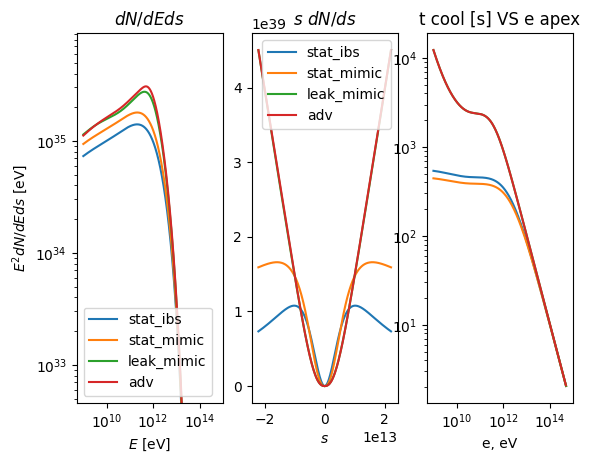

In [17]:
###  Let's do that for four different 
##### models of cooling: stat_ibs, stat_mimic, leak_mimic, and adv.
r = orb.r(t=t)
rpe = r - winds.dist_se_1d(t)
fig, ax = plt.subplots(nrows=1, ncols=3)

for cooling in ('stat_ibs',
                'stat_mimic',
                'leak_mimic', # can trigger some warnings, not tested, and doesn't work properly!
                'adv'
                ):
    if cooling in ('adv', 'leak_mimic'): eta_a = 1e20 # to dump ``adiabatic losses`` for advection model
    else: eta_a = 1 
    print(cooling)
    els = ElectronsOnIBS(
                         Bp_apex=1, 
                         ibs=ibs,
                         cooling=cooling, 
                         to_inject_e = 'ecpl', 
                         to_inject_theta = '3d', 
                         ecut = 5.e12,  
                         p_e = 1.8, 
                         to_cut_e = True,
                         emin = 1e9,
                         emin_grid=1e9,
                         emax = 5e14, 
                         norm_e = 1.e37, 
                         Bs_apex=0., 
                         eta_a = eta_a, 
                         eta_syn = 1.,
                         eta_ic = 1.,
                         to_cut_theta =  False, 
                         where_cut_theta = pi/2, 
                         ) 
    
    els.calculate()
    # print(els.edot(0, els.e_vals))
    # print(els.e_vals.shape)
    # print(els.emax)
    
    els.peek(ax=ax, 
             show_many=False # whether to show several spectra at several S. We don't need it here. Default is True
            )
    # if cooling == 'stat_mimic':
        # ax[3].plot(els.ibs.s[els.ibs.n:2*els.ibs.n], els.eta_a[:, 0])
    # ax[3].set_yscale('log')
    # smesh, emesh = np.meshgrid(els.ibs.s_dimless[els.ibs.n:2*els.ibs.n] * els.r_sp,
    #                            els.e_vals, indexing='ij')
    # ax[3].plot(els.ibs.s[els.ibs.n:2*els.ibs.n], -els.edot(smesh, emesh)[:, 0])
        
        

Now it's close to finish: let's calculate the spectrum of the IBS. We know its shape, we know everything about electrons emitting, so we can calculate the Synchrotron and inverse Compton emission. This is done using Naima code, so you should have it installed. As before, the description of all the needed parameters is given right in the Python code, but I want to comment on how the logic of the calcultion works.
- We get all parameters like magnetic and photon fields in apex and then recalculate them to every point of the IBS
- You also know the electrons spectrum $n_e(s, E)$ in the lab frame.
- If you want to: ``lorenrz_boost=True``, you can recalculate everything to the co-moving systems of frame $B\rightarrow B' = B\sqrt{\frac{2\Gamma^2+1}{3}}$, $u \rightarrow u' = u\Gamma^2 \frac{3+\beta^2}{3}$, \begin{equation}
        n(E) \rightarrow n'(E') = \frac{1}{2}\int_{-1}^1 \frac{n(E'\Gamma(1+\beta\mu'))}{\Gamma(1+\beta\mu')} d\mu'.
    \end{equation}
- Then, using either primed or not primed values, Sy+IC spectrum may be calcuated. For each $s$, Naima gives the SED $E'F'(E')$. It gets Doppler-boosted to the lab frame: $EF(E) = \delta^\mathrm{3~or~4} E'F'(E')\Bigg|_{E'=E/\delta}$. I am not sure what the power (3 or 4) should be of the Doppler factor $\delta = 1/(\Gamma(1-\beta \mu))$. Let's denote this power $p_\delta$. But anyay, the total spectrum is then summarized over the whole IBS:
\begin{equation}
        E F(E) = \frac{\int  (E'F'(E', s))^{\rm Naima} \times \delta_\mathrm{doppl}(s)^{p_\delta} ~ds}{\int ds} \Bigg|_{\nu' = \nu/\delta(s)}
\end{equation}

If you want to calculate the spectrum quicker, you can set ``simple=True`` to do it simpler (but slightly incorrectly). Then the \texttt{Naima} will calculate the SED only in the apex $(s=0)$, and this SED then will be rescaled to each point of the IBS by 
\begin{equation}
\begin{cases}
    \mathrm{SED}_\mathrm{Sy}(s) = \mathrm{SED}_\mathrm{Sy}(0) \times (B(s)/B(0))^2,\\
    \mathrm{SED}_\mathrm{IC}(s) = \mathrm{SED}_\mathrm{IC}(0) \times u_\gamma(s)/u_\gamma(0).
\end{cases}
\end{equation}

After that, the total spectrum will be doppler-boosted as explained above.


1.4469146449971557
Swift 0.3-10 keV flux is 5.634950792305358e-12
H.E.S.S. 0.4-100 TeV flux is 2.615475280064575e-11


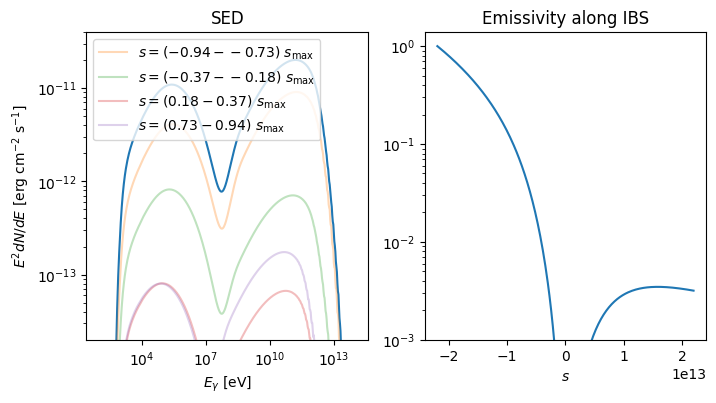

In [9]:
from ibsen.spec import SpectrumIBS
from scipy.optimize import curve_fit

def powerlaw(E, g, norm):
    return norm * E**(-g)

spec = SpectrumIBS(els=els, # els:ElectronsOnIBS class. Mandatory
                   simple=True, # Whether to calculate the spectrum in a simple fashion (see above). Default is False.
                   mechanisms=['syn', 'ic'],
                   apex_only=False,
                   delta_power=3, # The power p_delta (see above). Default is 4.
                   lorentz_boost=True, # Whether to perform Lorentz boost B, u_g, and n(s, E). Default is True.
                                       # If simple=True was set, the e-spectrum
                                       # n(s, E) will not be transformed, but the s-averaged spectrum (in lab frame) will be used instead. 
                   
                   abs_photoel=True, # Whether to include the TBabs-like photoelectric absorbtion. Default is True.
                   nh_tbabs=0.8, # If abs_photoel=True, this is the N_H (in units of 10^22) to use. Default is 0.8. 
                   abs_gg=False, # Whether to include the gamma-gamma absorbtion. Experimental feature, only for PSR B1259-63,
                                 # since it uses the tabulated values.
                   
                   distance = None # The distance to the system [cm]. Default is None. It will try to get the distance from the 
                                   # parameters that you provided for orbit:Orbit, but distance=<some_float> overwrites it.
                  )


E_ = np.logspace(2, 14, 500) 
(e_ph_here, # the grid of photon energies. It should be = E_, but I'm not sure hahhaaaa
 sed_here, # the total SED from IBS: 1-d array of length len(e_ph_here)
 sed_s_here # the SED from each point on IBS. 2-d array of shape (len(ibs.s), len(e_ph_here))
) = spec.calculate_sed_on_ibs(to_return=True, # If to return SED. Default is False
                                     to_set_onto_ibs=True, # If to remember the calculated spec, so you can access it as
                                                             # the class attributes later. Default is True.
                                     
                                     E = E_ # On which energies to calculate the spectrum. Default is np.logspace(2, 14, 1000).
                                     )
spec.peek()


#### Calculate the index of the spectrum in Swift energy range. 
#### To avoid effects of absorbtion, perform fitting over (3, 10) keV.
G_ind_swift = spec.index(e1 = 3e3, e2 = 1e4)
print(G_ind_swift)
###########################################################
emissiv_s = trapezoid(spec.sed_s/e_ph_here, e_ph_here, axis=1) # The total flux from the point on IBS

########### Calculate fluxes in keV and TeV ranges.
fl_swift, fl_hess = spec.fluxes( bands = (
                                          [3e2, 1e4],
                                          [4e11, 1e14]
                                         )
                               )
print('Swift 0.3-10 keV flux is', fl_swift)
print('H.E.S.S. 0.4-100 TeV flux is', fl_hess)

"How can the SED from only part of the IBS be larger than the total SED!?", --- you scream, enranged, irritated, terrified, scared. Look at you: I know exactly what you think, I'm reading you like an open book. Well, that concerns how exactly SED is calculated --- it is basically averaged over IBS, not summed, which, in turn, is so because Naima calculates not emissivity $j$, but the spectrum: SED. I'm not completely sure that is correct, by the way. 

I imagine you can be bored with initializing all these classes. If you just want one function to calculate the light curve, even if for just one moment of time, here is the function for that. What it does it:
 - initializes ``orbit:Orbit`` and ``winds:Winds`` classes 
 - for every moment of time, initializes ``ibs:IBS``, ``els:ElectronsOnIBS``, and ``spec:SpectrumIBS`` classes (and calculates everything)
 - stores everything.

**TODO** I have to write the interpolator for getting the approximate values of everything in any moment of time.

In [12]:
from ibsen.lc import LightCurve
t1 = np.linspace(-650, -40, 40) * DAY
t2 = np.linspace(-30, 90, 270) * DAY
t3 = np.linspace(100, 650, 40) * DAY
#ts = np.concatenate((t1, t2, t3))
ts=t2
lc = LightCurve(sys_name = 'psrb',
                n_ibs = 13,
                p_e = 1.7,
                times = ts,
                bands = ([3e2, 1e4],# [4e11, 1e13],
                        ),
                bands_ind = ([3e3, 1e4],),
                full_spec = False,
                to_parall = True, 
                f_d = 150,
                mechanisms=['syn', #'ic'
                           ],
                simple = True,
                apex_only=False,
                alpha_deg = -8.,
                s_max = 1,
                gamma_max=1.1,
                delta=0.015,
                cooling='stat_mimic',
                eta_a=1, # you may want to set that to 1e20 if cooling='adv'
                ns_field_surf=1,
                
                abs_gg=False,
               )
import time
start = time.time()
lc.calculate()
print(f'LC done in {time.time() - start}')


LC done in 5.478477954864502


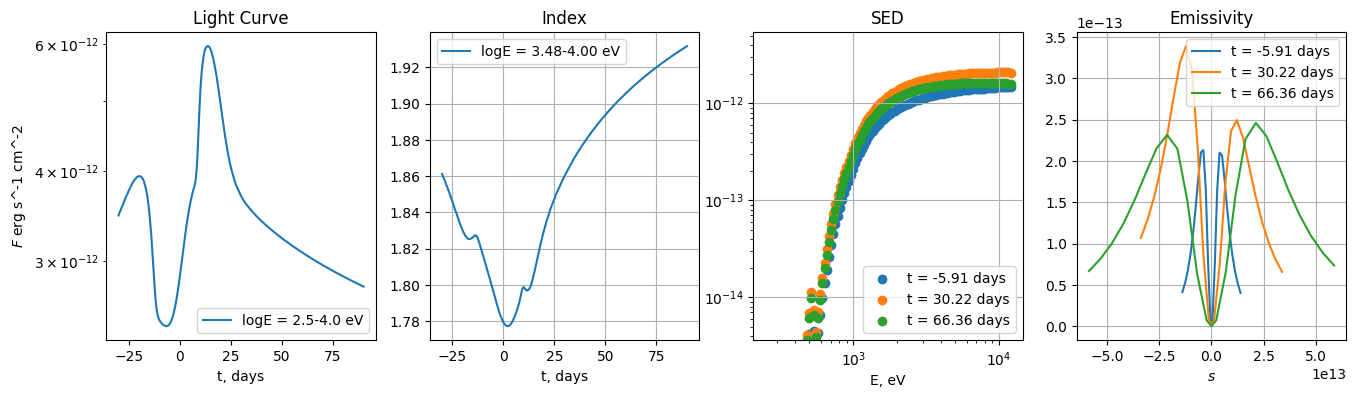

In [13]:
lc.peek()

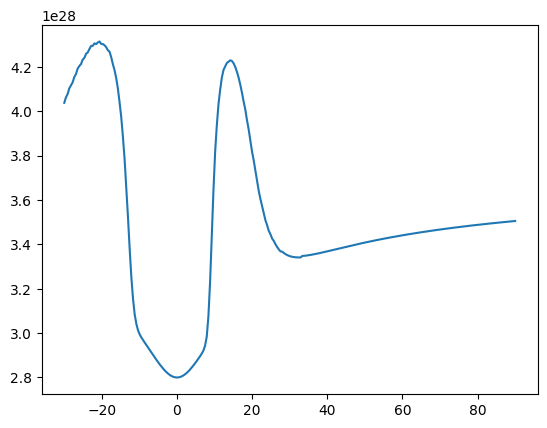

In [14]:
# plt.plot(lc.times/DAY, lc.fluxes)
from scipy.integrate import trapezoid

Ne_e = np.array([ np.sum(np.abs(trapezoid(lc.dNe_des[i], lc.e_es[i], axis=1))) for i in range(lc.times.size)])
plt.plot(lc.times/DAY, Ne_e)

TypeError: LightCurve.__init__() got an unexpected keyword argument 'syn_only'

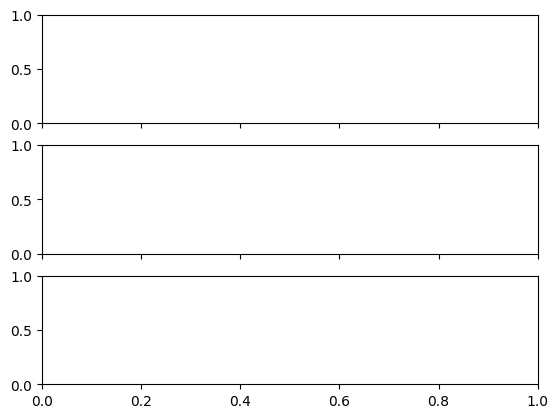

In [15]:
from ibsen.lc import LightCurve

fig, ax = plt.subplots(nrows=3, sharex=True)

t1 = np.linspace(-300, -40, 70) * DAY
t2 = np.linspace(-30, 90, 50) * DAY
t3 = np.linspace(100, 300, 70) * DAY
#ts = np.concatenate((t1, t2, t3))
ts=t2
#for cooling in ('stat_mimic', 'adv'):
for field in (0.01, 0.1, 1, 10):
    
    lc = LightCurve(sys_name = 'psrb',
                    n_ibs = 13,
                    p_e = 1.7,
                    times = ts,
                    bands = ([3e2, 1e4], [4e11, 1e14]),
                    bands_ind = ([3e3, 1e4],),
                    full_spec = False,
                    to_parall = True, 
                    f_d = 500,
                    syn_only = False,
                    simple = True,
                    alpha_deg = -8.,
                    s_max = 'bow',
                    gamma_max=2,
                    delta=0.02,
                    cooling='stat_mimic',
                    eta_a = 1e20,
                    ns_field_surf=field,
                    
                    abs_gg=True
                   )
    start = time.time()
    lc.calculate()
    print(f'LC done in {time.time() - start}')
    fluxes = lc.fluxes
    fl_sw, fl_hess = fluxes[:, 0], fluxes[:, 1]
    #fl_sw = lc.fluxes
    cond = np.logical_and(ts>-30*DAY, ts<50*DAY)
    ax[0].plot(ts/DAY, fl_sw/np.max(fl_sw[cond]), label = field)
    ax[1].plot(ts/DAY, fl_hess/np.max(fl_hess[cond]), label = field)
    
    #plt.plot(ts/DAY, lc.r_pes / lc.r_sps)
    tdisk1, tdisk2 = lc.winds.times_of_disk_passage
    for i_ in (0, 1):
        ax[i_].axvline(x=tdisk1/DAY, alpha=0.3)
        ax[i_].axvline(x=tdisk2/DAY, alpha=0.3)
        ax[i_].set_yscale('log')
    
    ax[2].plot(ts/DAY, lc.indexes, label = field)
ax[0].legend()
ax[1].legend()
ax[2].legend()

